# Experimenting with Higher Resolutions

So in this notebook, we're taking the architecture of our best performing model and this time we're going to tweak it so that it will take in photos with a resolution of 256x256 pixels. This will essentially be doubling the amount of data that the model is being trained on.  The hope here is that we'll be able to increase the accuracy since the images will be larger, even after passing through the filters of the convolution layers.  

In [1]:
# Loading our libraries

import warnings
warnings.filterwarnings('ignore')

import os, os.path
import glob
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import keras_preprocessing
import datetime
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models
import scipy
from PIL import Image
from scipy import ndimage
import cv2
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from keras.optimizers import Adam, SGD, RMSprop

Using TensorFlow backend.


In [23]:
# Copying over our generation parameters from our best model 

train_dir = '../chest_xray/train'
validation_dir = '../chest_xray/val'
test_dir = '../chest_xray/test'

# Rescaling
datagen = ImageDataGenerator(rescale=1./255) # rescaling the images 
aug_datagen = ImageDataGenerator(rescale=1./255,
                                rotation_range=30,
                                width_shift_range=0.15,
                                height_shift_range=0.15,
                                shear_range=0.1,
                                zoom_range=0.1,
                                vertical_flip=True,
                                fill_mode='nearest')
# Generating Data
# Changing target size to 256x256
train_gen = aug_datagen.flow_from_directory(train_dir,
                    target_size=(256, 256),
                    batch_size=5216,
                    class_mode='binary')

val_gen = datagen.flow_from_directory(validation_dir, 
                    target_size=(256, 256),
                    batch_size=16,
                    class_mode='binary')

test_gen = datagen.flow_from_directory(test_dir, 
                    target_size=(256, 256),
                    batch_size=624,
                    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [24]:
# Obtaining features and labels
train_img, train_labels = next(train_gen)
val_img, val_labels = next(val_gen)
test_img, test_labels = next(test_gen)

In [26]:
np.random.seed(42)

model_hi_rez2 = models.Sequential()

# Adjusting input shape to accomodate 
model_hi_rez2.add(layers.Conv2D(64, (3,3), padding='same', activation='relu', 
                        kernel_initializer='he_normal',
                        kernel_regularizer='l2',
                        input_shape=(256, 256, 3)))
# model.add(layers.BatchNormalization())
model_hi_rez2.add(layers.MaxPooling2D((2,2)))


model_hi_rez2.add(layers.Conv2D(128, (3,3), padding='same', 
                        kernel_initializer='he_normal',
                        kernel_regularizer='l2',
                        activation='relu'))
# model.add(layers.BatchNormalization())
model_hi_rez2.add(layers.MaxPooling2D((2,2)))

model_hi_rez2.add(layers.Conv2D(256, (3,3), padding='same', 
                        kernel_initializer='he_normal',
                        kernel_regularizer='l2',
                        activation='relu'))
# model.add(layers.BatchNormalization())
model_hi_rez2.add(layers.MaxPooling2D((2,2)))

model_hi_rez2.add(layers.Flatten())
model_hi_rez2.add(layers.Dense(64, kernel_initializer='he_normal',
                        kernel_regularizer='l2',
                       activation='relu'))
# model.add(layers.Dropout(0.2))
model_hi_rez2.add(layers.Dense(1, activation='sigmoid'))

model_hi_rez2.compile(loss='binary_crossentropy',
             optimizer='Adam',
             metrics=['acc'])
model_hi_rez2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 64, 64, 256)       295168    
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 32, 32, 256)       0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 262144)            0         
__________

In [27]:
history_hi_rez = model_hi_rez2.fit(train_img, train_labels,
                      callbacks=[keras.callbacks.EarlyStopping(monitor='val_acc',
                                         patience=30)],
                      batch_size=10,
                      epochs=40, 
                      validation_data=(val_img, val_labels))

Train on 5216 samples, validate on 16 samples
Epoch 1/40
5216/5216 [==============================] - 1274s 244ms/step - loss: 4.2827 - acc: 0.7494 - val_loss: 1.0256 - val_acc: 0.5000
Epoch 2/40
5216/5216 [==============================] - 1384s 265ms/step - loss: 0.5972 - acc: 0.7759 - val_loss: 0.9506 - val_acc: 0.5000
Epoch 3/40
5216/5216 [==============================] - 1407s 270ms/step - loss: 0.4697 - acc: 0.8395 - val_loss: 0.8082 - val_acc: 0.5625
Epoch 4/40
5216/5216 [==============================] - 1416s 271ms/step - loss: 0.4352 - acc: 0.8579 - val_loss: 0.7637 - val_acc: 0.6250
Epoch 5/40
5216/5216 [==============================] - 1401s 269ms/step - loss: 0.4125 - acc: 0.8600 - val_loss: 0.6013 - val_acc: 0.7500
Epoch 6/40
5216/5216 [==============================] - 1488s 285ms/step - loss: 0.3849 - acc: 0.8746 - val_loss: 0.9547 - val_acc: 0.6250
Epoch 7/40
5216/5216 [==============================] - 1333s 256ms/step - loss: 0.3793 - acc: 0.8750 - val_loss: 0.7733

In [28]:
model_hi_rez2.evaluate(test_img, test_labels)

624/624 [==============================] - 46s 74ms/step


[0.4655744830767314, 0.8397435897435898]

In [29]:
def plot_performance(model):
    """
    Input a trained model.
    
    Outputs plots of the Training and Validation accuracy and loss.  
    """
    
    acc = model.history['acc']
    val_acc = model.history['val_acc']
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'blue', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'red', label='Validation Accuracy')
    plt.title('Training and Validation accuracy')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, loss, 'blue', label='Training Loss')
    plt.plot(epochs, val_loss, 'red', label='Validation Loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()

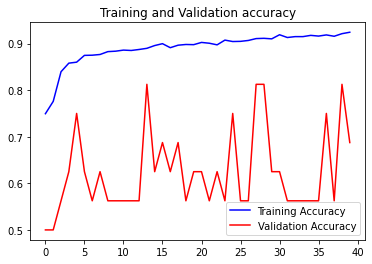

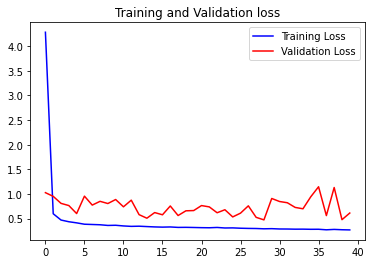

In [31]:
plot_performance(history_hi_rez)

# Evaluation:

Interesting... In addition to having roughly the same accuracy and loss results, we've actually increased the variance in the validation data.  Given, there were fewer epochs, but the plot above doesn't even hint at the values converging with more epochs.  One would think that with more data, we would at least have less variance, but that doesn't seem to be the case here.   